# Задача 1 Python: оценить результаты A/B-тестирования

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pandahouse as ph
from scipy import stats
from scipy.stats import norm, mannwhitneyu, ttest_ind, shapiro
import requests
from urllib.parse import urlencode
from tqdm.auto import tqdm

Загрузка данных и предвариетльный просмотр

In [101]:
#соберем все URL вместе и напишем функцию загрузки данных

url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
groups_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

def load_data (url, public_key, sep=';'):
    urls = url+urlencode({'public_key':public_key})
    get_urls = requests.get(urls).json()['href']
    data = requests.get(get_urls)
    return pd.read_csv(data.url, sep=sep)

groups = load_data(url, groups_url)
groups_add = load_data(url, groups_add_url)
active_studs = load_data(url, active_studs_url)
checks = load_data(url, checks_url)

#старый вариант без функции

#groups_url = url + urlencode(dict(public_key=groups))
#response_groups = requests.get(groups_url)
#download_groups_url = response_groups.json()['href']
#groups = pd.read_csv(download_groups_url, sep=';')


#groups_add_url = url + urlencode(dict(public_key=groups_add))
#response_groups_add = requests.get(groups_add_url)
#download_groups_add_url = response_groups_add.json()['href']
#groups_add = pd.read_csv(download_groups_add_url, sep=',')


#active_studs_url = url + urlencode(dict(public_key=active_studs))
#response_active_studs = requests.get(active_studs_url)
#download_active_studs_url = response_active_studs.json()['href']
#active_studs = pd.read_csv(download_active_studs_url, sep=';')


#checks_url = url + urlencode(dict(public_key=checks))
#response_checks = requests.get(checks_url)
#download_checks_url = response_checks.json()['href']
#checks = pd.read_csv(download_checks_url, sep=';')

In [102]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [103]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [104]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [105]:
groups.nunique()

id     74484
grp        2
dtype: int64

In [106]:
groups_add.head()

,"id,grp"
0,"5694584,B"
1,"5694830,B"
2,"5695057,B"
3,"5698872,B"
4,"5699067,B"


In [107]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id,grp  92 non-null     object
dtypes: object(1)
memory usage: 864.0+ bytes


In [108]:
groups_add.isna().sum()

id,grp    0
dtype: int64

In [109]:
groups_add.nunique()

id,grp    92
dtype: int64

In [110]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [111]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [112]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [113]:
active_studs.nunique()

student_id    8341
dtype: int64

In [114]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [115]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [116]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [117]:
checks.nunique()

student_id    541
rev            39
dtype: int64

для чистоты сразу объединим группы пользователей, для дальнейшего анализа

In [118]:
full_group = pd.concat([groups, groups_add], ignore_index=True)

In [119]:
full_group.head()

,id,grp,"id,grp"
0,1489.0,B,NaN
1,1627.0,A,NaN
2,1768.0,B,NaN
3,1783.0,B,NaN
4,1794.0,A,NaN


In [120]:
full_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      74484 non-null  float64
 1   grp     74484 non-null  object 
 2   id,grp  92 non-null     object 
dtypes: float64(1), object(2)
memory usage: 1.7+ MB


In [121]:
full_group.nunique()

id        74484
grp           2
id,grp       92
dtype: int64

In [122]:
groups.shape[0] + groups_add.shape[0]

74576

In [123]:
full_group.shape[0]

74576

In [124]:
full_group.head()

,id,grp,"id,grp"
0,1489.0,B,NaN
1,1627.0,A,NaN
2,1768.0,B,NaN
3,1783.0,B,NaN
4,1794.0,A,NaN


в целом данные чистые, нет дубликатов и пропусков
можно теперь соединить дату и проанализировать участников эксперимента

In [125]:
active_studs.rename(columns={'student_id':'id'}, inplace = True)

In [126]:
active_studs_in_full_group = active_studs.merge(full_group, how = 'left')

In [127]:
active_studs_in_full_group.head()

,id,grp,"id,grp"
0,581585,A,NaN
1,5723133,NaN,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


In [128]:
active_studs_in_full_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8341 non-null   int64 
 1   grp     8328 non-null   object
 2   id,grp  0 non-null      object
dtypes: int64(1), object(2)
memory usage: 260.7+ KB


In [129]:
checks.rename(columns={'student_id':'id'}, inplace = True)

In [130]:
active_group_checks = active_studs_in_full_group.merge(checks)

In [131]:
active_group_checks.head()

,id,grp,"id,grp",rev
0,1184303,A,NaN,1530.0000
1,3354191,B,NaN,1900.0001
2,3278734,B,NaN,1900.0000
3,720651,A,NaN,1980.0000
4,1232221,B,NaN,1900.0000


In [132]:
active_group_checks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      392 non-null    int64  
 1   grp     391 non-null    object 
 2   id,grp  0 non-null      object 
 3   rev     392 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 15.3+ KB


итого мы получили 392 активных юзера, которые совершали оплаты.
Для оценки новой МЕХАНИКИ ОПЛАТЫ мы отбросили остальных, также для определения методов оценки юзеров, необходимо проанализировать нормальность распределения

In [133]:
active_group_checks.grp.value_counts()

B    313
A     78
Name: grp, dtype: int64

Показываем разбиение аквтивных пользователей по группам

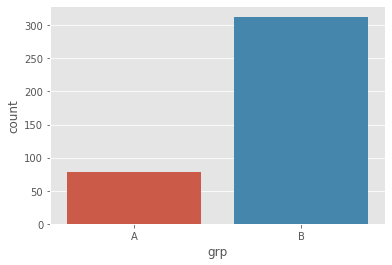

In [134]:
sns.countplot(x='grp', data=active_group_checks)

Показываем распределение активных пользователей с разбиением

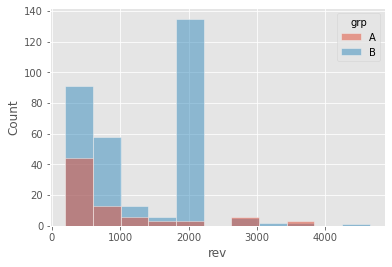

In [135]:
sns.histplot(x='rev', data = active_group_checks, hue = 'grp')


Посмотрим на выбросы в данных для определения возможности использования Т-Теста. Результат оценки будет определен в конце перед выбором теста

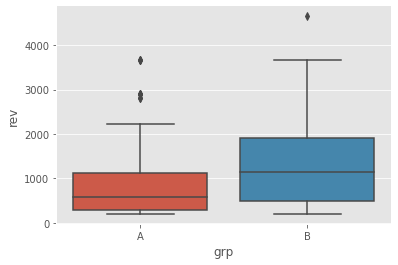

In [136]:
sns.boxplot(data=active_group_checks, y='rev', x='grp')
sns.despine()

In [137]:
active_group_checks.groupby('grp').rev.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,78.0,933.589744,919.932711,199.0,290.0,585.0,1114.75,3660.0
B,313.0,1255.827487,791.293377,199.0,489.0,1140.0,1900.00,4650.0


Распределение по группе пользователей А

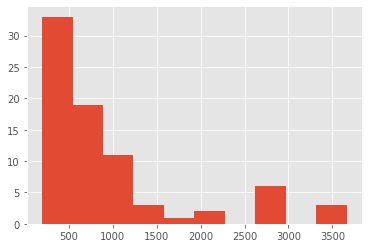

In [138]:
plt.hist(active_group_checks.query('grp == "A"').rev);

Распределение по группе пользователей В

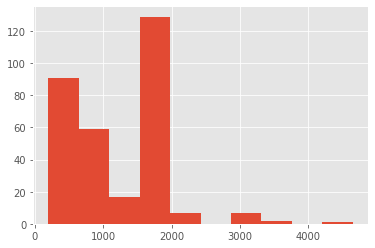

In [139]:
plt.hist(active_group_checks.query('grp == "B"').rev);

прогоним по тесту Шапиро на нормальность

In [140]:
group_a = active_group_checks.query('grp == "A"').rev
group_b = active_group_checks.query('grp == "B"').rev

In [141]:
print(shapiro(group_a))
print(shapiro(group_b))

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)
ShapiroResult(statistic=0.8551987409591675, pvalue=1.756778758085431e-16)


Опираясь на данные графиков, таблицы распределения и теста Шапиро можно заявить, что распределение не является нормальным, следовательно круг методов сужается и проще использовать bootstrap

Через bootstrap будем смотреть отношение итого суммы покупки для количества активных оплативших пользователей, те ARPPU.


Сформулируем гипотезу:

ARPPU

Н0 - ARPPU не различаются

Н1 - ARPPU имеют различия

In [142]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000,
    statistic=np.mean,
    bootstrap_conf_level=0.95,
    graf=True
):
    boot_data = []
    boot_len=max(len(data_column_1), len(data_column_2))
    
    
    for i in range(boot_it):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

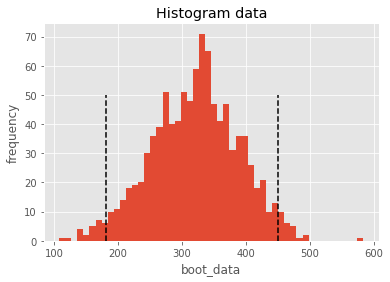

In [143]:
groups_bootstrap = get_bootstrap(group_b, group_a)

In [144]:
groups_bootstrap['p_value']

2.4115275359469656e-06

In [145]:
groups_bootstrap['quants']

,0
0.025,181.563907
0.975,450.338910


Значение p-value меньше 0.05, значит различия в выборках статистически значимы и 0 не попадает в доверительный интервал
Отвергаем Н0


Давайте также рассчитваем основные метрики и посмотрим на ARPU и CR

отношение итого суммы покупки для количества всех активных пользователей, те ARPU.
конверсия оплаты, отношение количества активных оплативших пользователей к количеству всех активных пользователей - CR

Сформулируем гипотезу для ARPU:

Н0 - значения в группах не различаются
Н1 - значения в группах имеют различия

In [146]:
df_checks = checks

In [147]:
df_checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [148]:
df_checks['cnt'] = 'y'

In [149]:
df_to_cr = active_studs_in_full_group.merge(df_checks, how = 'left')
df_to_cr['cnt'].fillna('n', inplace=True)
df_to_cr.fillna(0, inplace=True)
df_to_cr.head()

,id,grp,"id,grp",rev,cnt
0,581585,A,0,0.0,n
1,5723133,0,0,0.0,n
2,3276743,B,0,0.0,n
3,4238589,A,0,0.0,n
4,4475369,B,0,0.0,n


создаем таблицу для расчета CR

In [150]:
df_to_cr_data = df_to_cr.groupby(['grp', 'cnt']).agg({'rev': 'count'}).reset_index()
df_to_cr_data

,grp,cnt,rev
0,0,n,12
1,0,y,1
2,A,n,1457
3,A,y,78
4,B,n,6480
5,B,y,313


In [151]:
cr_data_full = df_to_cr_data.pivot(index='grp', columns='cnt', values='rev')
cr_data_full.head()

cnt,n,y
grp,,
0,12,1
A,1457,78
B,6480,313


In [152]:
cr_data_full['CR'] = (cr_data_full.y / (cr_data_full.y+cr_data_full.n) * 100).round(2)

In [153]:
CR = ((cr_data_full.y / (cr_data_full.n + cr_data_full.y)) * 100).round(2)
CR

grp
0    7.69
A    5.08
B    4.61
dtype: float64

Значения очень близки. Те особого эффекта не оказывается, так что давайте посмотрим на ARPU и после будем принимать решение

In [154]:
cr_data_full.head()

cnt,n,y,CR
grp,,,
0,12,1,7.69
A,1457,78,5.08
B,6480,313,4.61


In [155]:
arpu_a = df_to_cr[df_to_cr['grp'] == 'A'].rev
arpu_b = df_to_cr[df_to_cr['grp'] == 'B'].rev

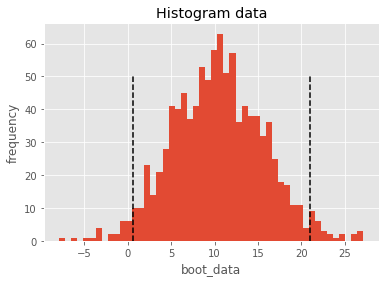

In [156]:
arpu_bootstrap = get_bootstrap(arpu_b, arpu_a)

In [157]:
arpu_bootstrap['p_value']

0.04601314615988512

In [158]:
arpu_bootstrap['quants']

,0
0.025,0.554523
0.975,21.044786


Значение p-value меньше 0.05, значит различия в выборках статистически значимы и 0 не попадает в доверительный интервал
Отвергаем Н0

In [159]:
arpu_a_group = round(df_to_cr[(df_to_cr['grp'] == 'A') & (df_to_cr['cnt'])]['rev'].mean(), 2)
arpu_b_group = round(df_to_cr[(df_to_cr['grp'] == 'B') & (df_to_cr['cnt'])]['rev'].mean(), 2)

In [160]:
arpu = pd.DataFrame({
    'grp': ['A', 'B'],
    'arpu': [arpu_a_group, arpu_b_group]})
arpu

,grp,arpu
0,A,47.44
1,B,57.86


In [161]:
arppu_a_group = round(df_to_cr[(df_to_cr['grp'] == 'A') & (df_to_cr['cnt'] == 'y')]['rev'].mean(), 2)
arppu_b_group = round(df_to_cr[(df_to_cr['grp'] == 'B') & (df_to_cr['cnt'] == 'y')]['rev'].mean(), 2)

In [162]:
arppu = pd.DataFrame({
    'grp': ['A', 'B'],
    'arppu': [arppu_a_group, arppu_b_group]})
arppu

,grp,arppu
0,A,933.59
1,B,1255.83


In [163]:
full_analys = cr_data_full.merge(arpu, on = 'grp')
full_analys = full_analys.merge(arppu, on = 'grp')

In [164]:
del full_analys['n']
del full_analys['y']

In [165]:
full_analys.head()

,grp,CR,arpu,arppu
0,A,5.08,47.44,933.59
1,B,4.61,57.86,1255.83


Итог наших преобразований данных:
На основании нашего анализа, посмотрев чистоту данных, распределение, проведя анализ и выведя основные показатели можно заявить, что мы получили различия в тестовой и контрольной группе и новый алгоритм повлиял на сам факт оплаты и средний чек.
Есть основания для наката новой механики на всю группу пользователей

# Задание 2 SQL - Провести расчеты и анализ данных 

Задача: подключиться к базе clickhouse. Определить активных студентов, выполняющих задания на образовательных курсах

In [166]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [167]:
query_1 = """
SELECT
    COUNT(DISTINCT(st_id)) as top_students
FROM(
    SELECT
        st_id, toStartOfMonth(timest) as mmonth
    FROM
        peas
    GROUP BY
        st_id, mmonth
    HAVING 
        sum(correct) >=20)
"""        
df_1 = ph.read_clickhouse(query_1, connection=connection)
df_1

,top_students
0,136


Задание 2: необходимо просчитать основные показатели ARPU, ARPAU, CR в покупку, CR активного пользователя в покупку и CR пользователя по математике в покупку

Для начала соберем таблицы топовым активным студентам и проставим им 1 или 0, чтобы потом легче было считать и заодно проставим по ним сумму трат (кто делал покупку)

SELECT
    l.st_id as st_id,
    l.top_stud as top_stud,
    l.top_stud_math as top_stud_math,
    r.total_money as total_money,
    r.math_money as math_money
FROM (
    SELECT
    st_id,
    if (sum(correct) > 10, 1, 0) as top_stud,
    if (sumIf(correct, subject='Math') >= 2, 1, 0) as top_stud_math
    FROM 
        peas
    GROUP BY
        st_id
     ) as l
    LEFT JOIN (
    SELECT
        st_id,
        sum(money) as total_money,
        sumIf(money, subject='Math') as math_money
    FROM 
        final_project_check
    GROUP BY 
        st_id
    ) as r
    ON l.st_id = r.st_id
    
Далее присоединим эту таблицу к группе studs, чтобы оценить по контрольным группам студентов и создадим одну 
большую таблицу из которой уже и будем считать основные показатели

SELECT
    l.test_grp as test_grp,
    l.st_id as id,
    r.top_stud as top_students,
    r.top_stud_math as top_students_math,
    r.total_money as total_money,
    r.math_money as math_money
FROM (
    SELECT
        test_grp,
        st_id
    FROM 
        studs)
    as l
LEFT JOIN (...
)
ON l.st_id = r.st_id
    )


In [168]:
query_2 = """
SELECT
    test_grp,
    ROUND(SUM(total_money) / COUNT(total_money),2) AS ARPU,
    ROUND(sumIf(total_money, top_students=1) / countIf(top_students, top_students=1),2) AS ARPAU,
    ROUND((countIf(id, total_money>0) / count(id))*100,2) AS CR,
    ROUND((countIf(id, total_money>0 and top_students=1) / countIf(id, top_students=1))*100,2) AS CR_top_students,
    ROUND((countIf(id, math_money>0 and top_students_math=1) / countIf(id, top_students_math=1))*100,2) AS CR_top_students_math
FROM (
    SELECT
        l.test_grp as test_grp,
        l.st_id as id,
        r.top_stud as top_students,
        r.top_stud_math as top_students_math,
        r.total_money as total_money,
        r.math_money as math_money
    FROM (
        SELECT
            test_grp,
            st_id
        FROM 
            studs)
        as l
    LEFT JOIN (
        SELECT
            l.st_id as st_id,
            l.top_stud as top_stud,
            l.top_stud_math as top_stud_math,
            r.total_money as total_money,
            r.math_money as math_money
        FROM (
            SELECT
                st_id,
                if (sum(correct) > 10, 1, 0) as top_stud,
                if (sumIf(correct, subject='Math') >= 2, 1, 0) as top_stud_math
            FROM 
                peas
            GROUP BY
                st_id
            ) as l
            LEFT JOIN (
            SELECT
                st_id,
                sum(money) as total_money,
                sumIf(money, subject='Math') as math_money
            FROM 
                final_project_check
            GROUP BY 
                st_id
            ) as r
            ON l.st_id = r.st_id
        ) as r
    ON l.st_id = r.st_id
    ) 
GROUP BY
    test_grp
"""        
df_2 = ph.read_clickhouse(query_2, connection=connection)
df_2

,test_grp,ARPU,ARPAU,CR,CR_top_students,CR_top_students_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11067.80,29739.58,10.17,26.04,9.52


# Задание 3 Python - необходимо реализовать функцию загрузки и анализа новых данных по результатам A/B-тестирования

Опираясь на ранее проведенный анализ

In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pandahouse as ph
from scipy import stats
from scipy.stats import norm, mannwhitneyu, ttest_ind, shapiro
import requests
from urllib.parse import urlencode
from tqdm.auto import tqdm

In [170]:
def update_metrix():
    url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
    groups_url = url + urlencode(dict(public_key=groups))
    response_groups = requests.get(groups_url)
    download_groups_url = response_groups.json()['href']
    groups = pd.read_csv(download_groups_url, sep=';')

    active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
    active_studs_url = url + urlencode(dict(public_key=active_studs))
    response_active_studs = requests.get(active_studs_url)
    download_active_studs_url = response_active_studs.json()['href']
    active_studs = pd.read_csv(download_active_studs_url, sep=';')
    active_studs['active'] = 'y'
    active_studs = active_studs.rename(columns={'student_id':'id'})

    checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
    checks_url = url + urlencode(dict(public_key=checks))
    response_checks = requests.get(checks_url)
    download_checks_url = response_checks.json()['href']
    checks = pd.read_csv(download_checks_url, sep=';')
    checks['paid'] = 'y'
    checks = checks.rename(columns={'student_id':'id'})

    groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
    groups_add_url = url + urlencode(dict(public_key=groups_add))
    response_groups_add = requests.get(groups_add_url)
    download_groups_add_url = response_groups_add.json()['href']
    groups_add = pd.read_csv(download_groups_add_url, sep=',', names = ['id', 'grp'], header =0)
    
    df = pd.concat([groups, groups_add], ignore_index=True)
    df = df.merge(active_studs, how = 'outer')
    df['active'].fillna('n', inplace=True)
    df = df.merge(checks, how = 'outer')
    df['rev'].fillna(0, inplace=True)
    df['paid'].fillna('n', inplace=True)
    
    cr_a = round((df[(df['grp'] == 'A') & (df['active'] == 'y')& (df['paid'] == 'y')]['rev'].count()/df[(df['grp'] == 'A') & (df['active'] == 'y')]['rev'].count())*100, 2)
    cr_b = round((df[(df['grp'] == 'B') & (df['active'] == 'y')& (df['paid'] == 'y')]['rev'].count()/df[(df['grp'] == 'B') & (df['active'] == 'y')]['rev'].count())*100, 2)
    arpu_a_grp = round(df[(df['grp'] == 'A') & (df['paid'])]['rev'].mean(), 2)
    arpu_b_grp = round(df[(df['grp'] == 'B') & (df['paid'])]['rev'].mean(), 2)
    arppu_a_grp = round(df[(df['grp'] == 'A') & (df['paid'] == 'y')]['rev'].mean(), 2)
    arppu_b_grp = round(df[(df['grp'] == 'B') & (df['paid'] == 'y')]['rev'].mean(), 2)
    
    metrix = pd.DataFrame({
    'grp': ['A', 'B'],
    'cr': [cr_a, cr_b],
    'arpu': [arpu_a_grp, arpu_b_grp],
    'arppu': [arppu_a_grp, arppu_b_grp]})
    
    return metrix
    


In [171]:
update_metrix()

,grp,cr,arpu,arppu
0,A,5.07,6.27,860.71
1,B,4.62,8.04,1108.82


In [172]:
def update_graf():
    
    ###
    url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
    groups_url = url + urlencode(dict(public_key=groups))
    response_groups = requests.get(groups_url)
    download_groups_url = response_groups.json()['href']
    groups = pd.read_csv(download_groups_url, sep=';')

    active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
    active_studs_url = url + urlencode(dict(public_key=active_studs))
    response_active_studs = requests.get(active_studs_url)
    download_active_studs_url = response_active_studs.json()['href']
    active_studs = pd.read_csv(download_active_studs_url, sep=';')
    active_studs['active'] = 'y'
    active_studs = active_studs.rename(columns={'student_id':'id'})

    checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
    checks_url = url + urlencode(dict(public_key=checks))
    response_checks = requests.get(checks_url)
    download_checks_url = response_checks.json()['href']
    checks = pd.read_csv(download_checks_url, sep=';')
    checks['paid'] = 'y'
    checks = checks.rename(columns={'student_id':'id'})

    groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
    groups_add_url = url + urlencode(dict(public_key=groups_add))
    response_groups_add = requests.get(groups_add_url)
    download_groups_add_url = response_groups_add.json()['href']
    groups_add = pd.read_csv(download_groups_add_url, sep=',', names = ['id', 'grp'], header =0)
    
    df = pd.concat([groups, groups_add], ignore_index=True)
    df = df.merge(active_studs, how = 'outer')
    df['active'].fillna('n', inplace=True)
    df = df.merge(checks, how = 'outer')
    df['rev'].fillna(0, inplace=True)
    df['paid'].fillna('n', inplace=True)
    
    cr_a = round((df[(df['grp'] == 'A') & (df['active'] == 'y')& (df['paid'] == 'y')]['rev'].count()/df[(df['grp'] == 'A') & (df['active'] == 'y')]['rev'].count())*100, 2)
    cr_b = round((df[(df['grp'] == 'B') & (df['active'] == 'y')& (df['paid'] == 'y')]['rev'].count()/df[(df['grp'] == 'B') & (df['active'] == 'y')]['rev'].count())*100, 2)
    arpu_a_grp = round(df[(df['grp'] == 'A') & (df['paid'])]['rev'].mean(), 2)
    arpu_b_grp = round(df[(df['grp'] == 'B') & (df['paid'])]['rev'].mean(), 2)
    arppu_a_grp = round(df[(df['grp'] == 'A') & (df['paid'] == 'y')]['rev'].mean(), 2)
    arppu_b_grp = round(df[(df['grp'] == 'B') & (df['paid'] == 'y')]['rev'].mean(), 2)
    
    metrix = pd.DataFrame({
    'grp': ['A', 'B'],
    'cr': [cr_a, cr_b],
    'arpu': [arpu_a_grp, arpu_b_grp],
    'arppu': [arppu_a_grp, arppu_b_grp]})
    ###
    
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(13, 8))
    sns.barplot(ax=axes[0], y='cr', x='grp', data=metrix,  hue='grp', palette='bright')
    sns.barplot(ax=axes[1], y='arpu', x='grp', data=metrix, hue='grp', palette='bright')
    sns.barplot(ax=axes[2], y='arppu', x='grp', data=metrix, hue='grp', palette='bright')

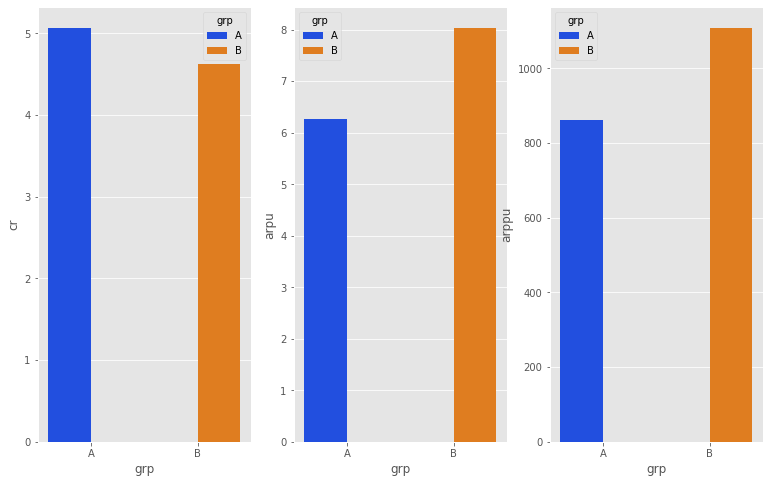

In [173]:
update_graf()